# Working with the Unusable Data Mask (UDM)

## Introduction
The Unusable Data Mask (UDM) is provided with many Planet products. It provides pixel-by-pixel information on quality issues that may affect the usability of each pixel, depending on the application. Specifications for the UDM are given in the [Imagery Spec Sheet](https://assets.planet.com/docs/combined-imagery-product-spec-april-2019.pdf) and the [UDM-2 API documentation](https://developers.planet.com/docs/api/udm-2/).

The UDM is an 8-bit single-band image. Pixel quality issues are bit-encoded. For example, if Bit 0 is set to 1 for a pixel in the UDM, then the pixel is in an area that was not imaged by the spacecraft, and the pixel is 'blackfill'. If all bits are set to zero, there is no quality issue with the pixel. The full description of UDM bit meanings is given below.

How we convert a UDM to a mask depends on which quality issues we are concerned about. If we require no quality issues, then we mask out all pixels that have a non-zero value (any bits set to 1). However, if we have our own cloud detection algorithm and do not want to exclude pixels that are suspected to be cloud covered, then we mask out all pixels that have bits other than Bit 1 (cloud-covered) set to 1.

In this notebook, we demonstrate downloading, visualizing, and converting the UDM to a binary mask. The UDM is basically a classified image, where the binary representation provides the bit-encoded quality information. Therefore, we visualize the UDM as such. Next we convert the UDM to a binary mask for use in masking the scene. We create two different masks: one where all pixels with quality concerns are masked and another where pixels with quality concerns in the NIR are not masked.

### UDM Bit Description

The UDM bit description is copied from the [Imagery Spec Sheet](https://assets.planet.com/docs/combined-imagery-product-spec-april-2019.pdf) and given here for convenience in interpreting the UDM.

* Bit 0: Identifies whether the area contains blackfill in all bands (this area was not imaged by the spacecraft). A value of “1” indicates blackfill.
* Bit 1: Identifies whether the area is cloud covered. A value of “1” indicates cloud covered. Cloud detection is performed on a decimated version of the image (i.e. the browse image) and hence small clouds may be missed. Cloud areas are those that have pixel values in the assessed band (Red, NIR or Green) that are above a configurable threshold. This algorithm will:
  Assess snow as cloud;
  Assess cloud shadow as cloud free;
  Assess haze as cloud free.
* Bit 2: Identifies whether the area contains missing (lost during downlink) or suspect (contains down- link errors) data in the Blue band. A value of “1” indicates missing/suspect data. If the product does not include this band, the value is set to “0”.
* Bit 3: Identifies whether the area contains missing (lost during downlink and hence blackfilled) or sus- pect (contains downlink errors) data in the Green band. A value of “1” indicates missing/suspect data. If the product does not include this band, the value is set to “0”.
* Bit 4: Identifies whether the area contains missing (lost during downlink) or suspect (contains down- link errors) data in the Red band. A value of “1” indicates missing/suspect data. If the product does not include this band, the value is set to “0”.
* Bit 5: Identifies whether the area contains missing (lost during downlink) or suspect (contains downlink errors) data in the Red Edge band. A value of “1” indicates missing/suspect data. If the product does not include this band, the value is set to “0”.
* Bit 6: Identifies whether the area contains missing (lost during downlink) or suspect (contains down- link errors) data in the NIR band. A value of “1” indicates missing/suspect data. If the product does not include this band, the value is set to “0”.
* Bit 7: Is currently set to “0”.

## Install Dependencies and Set up Notebook

In [3]:
from collections import OrderedDict
import os
import subprocess

import matplotlib
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import rasterio

%matplotlib inline

## Download UDM

To download the udm, we use the planet CLI because it handles activating, waiting for activation, and downloading the file.

We will save the udm in the `data` folder. This folder isn't tracked by git so the downloaded image file will not bloat our git repository.

In [4]:
# create the data folder if it doesn't exist
data_folder = 'data'
if not os.path.isdir(data_folder): os.mkdir(data_folder)

In [5]:
!planet data download --item-type PSOrthoTile \
                      --asset-type udm \
                      --string-in id 210879_1558814_2016-07-25_0e16 \
                      --dest data

activating: 0            complete: 0              elapsed: 0                    
paging: False            pending: 0                                             

activating: 0            complete: 0              elapsed: 1                    
paging: False            pending: 0                                             

activating: 0            complete: 0              downloaded: 0.00MB            
downloading: 0           elapsed: 2               paging: False                 
pending: 1                                                                      

activating: 0            complete: 0              downloaded: 0.00MB            
downloading: 0           elapsed: 2               paging: False                 
pending: 1                                                                      
2019-04-05 00:25:30,079 - FuturesSession - WARNING - `background_callback` is
deprecated and will be removed in 1.0, use `hooks` instead
activating: 0            complete: 0              

In [6]:
# store the udm filename for processing and make sure the file exists
udm_filename = os.path.join('data', '210879_1558814_2016-07-25_0e16_BGRN_DN_udm.tif')
print(udm_filename)
assert os.path.isfile(udm_filename)

data/210879_1558814_2016-07-25_0e16_BGRN_DN_udm.tif


## Visualize UDM

Since the UDM is bit-encoded, its scale is not linear. In fact, each unique value represents a different quality classification. Therefore, we will treat it as a classified image. To visualize the UDM as a classified image, we will first define some utility functions for visualizing a classified band with matplotlib.

### Visualizing a Classified Band

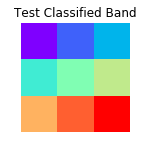

In [7]:
def plot_classified_band(class_band, class_labels=None, cmap='rainbow',
                         title='Class Labels', figdim=10):
    fig = plt.figure(figsize=(figdim, figdim))
    ax = fig.add_subplot(1, 1, 1)
    imshow_class_band(ax, class_band, class_labels, cmap=cmap)
    ax.set_title(title)
    ax.set_axis_off()

def imshow_class_band(ax, class_band, class_labels=None, cmap='rainbow'):
    """Show classified band with colormap normalization and color legend. Alters ax in place.
    
    possible cmaps ref: https://matplotlib.org/examples/color/colormaps_reference.html
    """
    class_norm = _ClassNormalize(class_band)
    im = ax.imshow(class_band, cmap=cmap, norm=class_norm)

    try:
        # add class label legend
        # https://stackoverflow.com/questions/25482876
        # /how-to-add-legend-to-imshow-in-matplotlib
        color_mapping = class_norm.mapping
        colors = [im.cmap(color_mapping[k]) for k in class_labels.keys()]
        labels = class_labels.values()

        # https://matplotlib.org/users/legend_guide.html
        # tag: #creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
        patches = [mpatches.Patch(color=c, label=l) for c,l in zip(colors, labels)]

        ax.legend(handles=patches, bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.)
    except AttributeError:
        # class_labels not specified
        pass

# https://matplotlib.org/users/colormapnorms.html#custom-normalization-two-linear-ranges
class _ClassNormalize(colors.Normalize):
    """Matplotlib colormap normalizer for a classified band.
    
    Inspired by https://matplotlib.org/users/colormapnorms.html#custom-normalization-two-linear-ranges
    """
    def __init__(self, arry):
        # get unique unmasked values
        values = [v for v in np.unique(arry)
                  if not isinstance(v, np.ma.core.MaskedConstant)]

        # map unique values to points in the range 0-1
        color_ticks = np.array(range(len(values)), dtype=np.float) / (len(values) - 1)
        self._mapping = dict((v, ct) for v, ct in zip(values, color_ticks))
        
        # Initialize base Normalize instance
        vmin = 0
        vmax = 1
        clip = False
        colors.Normalize.__init__(self, vmin, vmax, clip)
    
    def __call__(self, arry, clip=None):
        '''Create classified representation of arry for display.'''
        # round array back to ints for logical comparison
        arry = np.around(arry)
        new_arry = arry.copy()
        for k, v in self._mapping.items():
            new_arry[arry==k] = v
        return new_arry
    
    @property
    def mapping(self):
        '''property required for colors.Normalize classes
        
        We update the _mapping property in __init__ and __call__ and just
        return that property here.
        '''
        return self._mapping
    
# test out classified band visualization
test_classified_band = np.array(range(9)).reshape((3,3))
plot_classified_band(test_classified_band, title='Test Classified Band', figdim=2)

### Load and Visualize UDM

In [18]:
# Utility functions for loading a UDM image and identifying 
# binary representation as class labels
def load_udm(udm_filename):
    '''Load single-band bit-encoded UDM as a 2D array.'''
    with rasterio.open(udm_filename, 'r') as src:
        udm = src.read()[0,...]
    return udm

def get_udm_labels(udm):
    '''Get the interpretation of the UDM binary values'''    
    def get_label(v):
        if v == 0:
            label = 'clear'
        elif v == 1:
            label = 'blackfill'
        else:
            labels = []
            if v & int('10',2):
                labels.append('cloud')
            if v & int('1111100',2):
                bands = []
                if v & int('100',2):
                    bands.append('Blue')
                if v & int('1000', 2):
                    bands.append('Green')
                if v & int('10000', 2):
                    bands.append('Red')
                if v & int('100000', 2):
                    bands.append('Red-Edge')
                if v & int('1000000', 2):
                    bands.append('NIR')
                labels.append('missing/suspect {} data'.format(', '.join(bands)))
                
            
            if not len(labels):
                labels.append('{0:08b}'.format(v))

            label = ', '.join(labels)
        return label

    return OrderedDict((v, get_label(v)) for v in np.unique(udm))

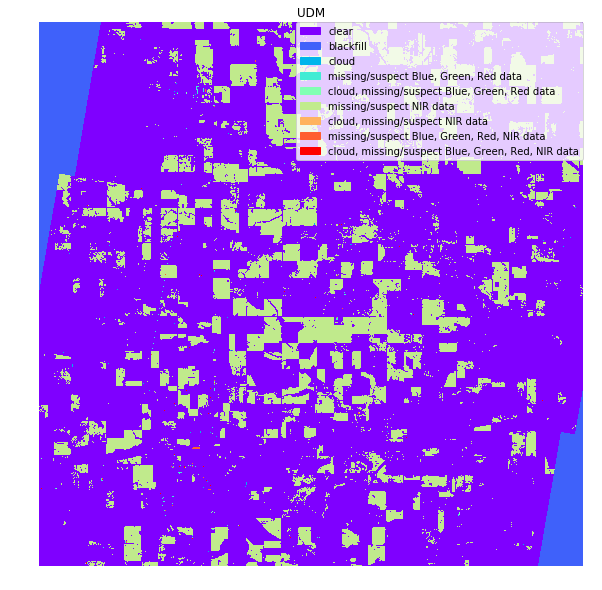

In [19]:
udm = load_udm(udm_filename)
udm_labels = get_udm_labels(udm)
plot_classified_band(udm, class_labels=udm_labels, title='UDM')

With this visualization, we can easily see the pixels with quality concerns. The upper-left and lower-right corners contain blackfill (Bit 1 is set to 1). Throughout the image, there are several rectangles that have suspect NIR data (Bit 6 is set to 1) - likely saturation in the NIR band. There are just a few pixels that may have cloud cover (Bit 1 set to 1), and/or suspect Blue, Green or Red data (Bits 2, 3, and 4, respectively).

## Convert UDM to Mask

In this section, we convert the UDM to a boolean mask that can be applied to the scene. In the mask, pixels with `True` (Integer representation is `1`) values are masked, pixels with `False` (Integer representation is `0`) values are not masked. We will create two different masks. First, we will mask out all pixels with quality concerns. This is the most likely use case. Second, we will not mask pixels that have suspect NIR values. This would apply to a use case where we only want to work with the visible (RGB) bands and aren't concerned with quality issues in the NIR band.

### Mask all Pixels with Quality Concerns

In [8]:
mask_class_labels = {0: 'unmasked', 1: 'masked'}
mask_cmap = 'viridis' # looks better when just two colors are displayed

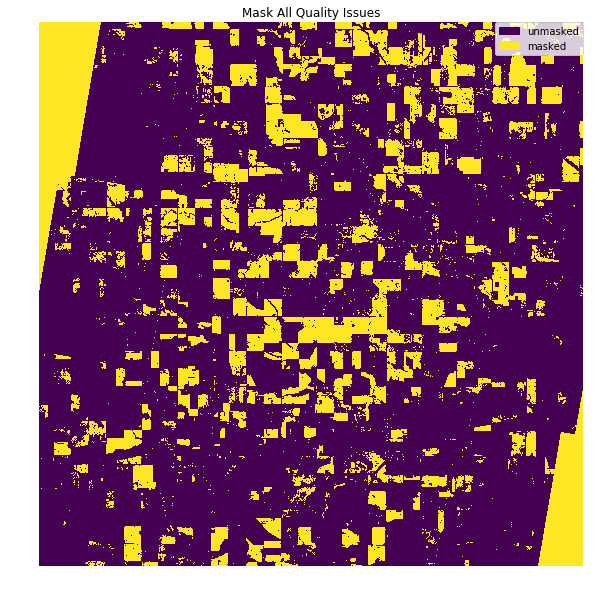

In [9]:
def udm_to_mask_all(udm_array):
    '''Create a mask from the udm, masking all pixels with quality concerns''' 
    return udm_array != 0

plot_classified_band(udm_to_mask_all(udm),
                     class_labels=mask_class_labels,
                     cmap=mask_cmap,
                     title='Mask All Quality Issues')

### Mask Pixels with RGB Quality Concerns

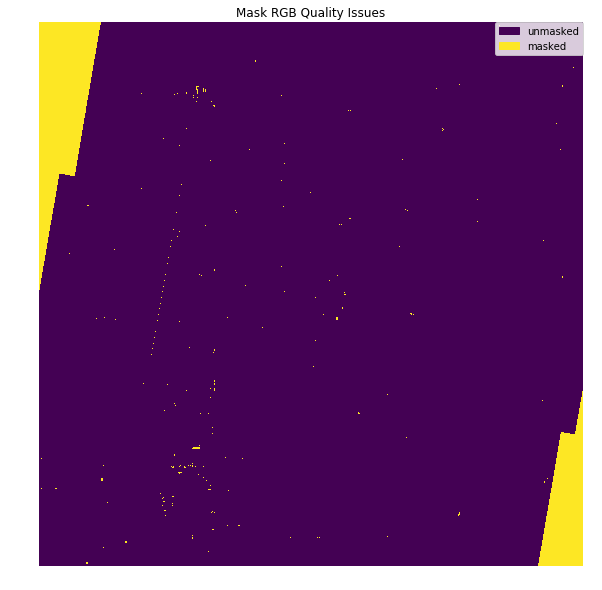

In [10]:
def udm_to_mask_rgb(udm_array):
    '''Create a mask from the udm, masking only pixels with RGB quality concerns''' 
    # RGB quality concern Bits: 0, 1, 2, 3, 4, 
    test_bits = int('00011111',2) # check for bits 1,2,3,4
    bit_matches = udm_array & test_bits # bit-wise logical AND operator
    return bit_matches != 0 # mask any pixels that match test bits

plot_classified_band(udm_to_mask_rgb(udm),
                     class_labels=mask_class_labels,
                     cmap=mask_cmap,
                     title='Mask RGB Quality Issues')

## Conclusion

In this notebook, we have downloaded the UDM, visualized it with the binary representation of the values, interpreted the binary representation using the Bit value information, and converted the UDM to two different masks with different definitions of pixel quality concerns that should be masked.